In [1]:
import glob
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import shapely
import matplotlib.colors as colors
from IPython.display import clear_output
from tqdm.notebook import tqdm
import time
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_95456\1679906244.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
####### IMPORT DATA
cell_geo = pd.read_pickle("./dataframes/cell_geometry")
cell = geopandas.GeoDataFrame(cell_geo, columns=['geometry'], 
                                 crs='epsg:4326')

jsonfile = ('./ark28722-s73w23-geojson.json')
world = geopandas.read_file(jsonfile)

fires = pd.read_pickle("./dataframes/all_fires")
fires = fires[~fires["GIS_ACRES"].isnull()]
fires = fires[~fires.duplicated()]
fires = fires[~fires[["FIRE_NAME", "INC_NUM", "ALARM_DATE", "CONT_DATE", "CAUSE", "geometry"]].duplicated()]

fires = fires.loc[(fires["YEAR"] >= 2000) & (fires["YEAR"] <= 2019) & (fires["MONTH"] >= 6) & (fires["MONTH"] <= 10)]

<Axes: >

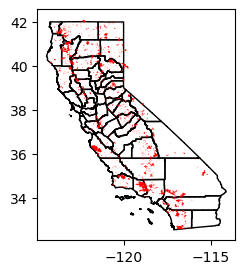

In [3]:
ax = world.to_crs(cell.crs).plot(color = "none", edgecolor = 'black', figsize = (5,3))
fires.plot(ax = ax, color = "red")

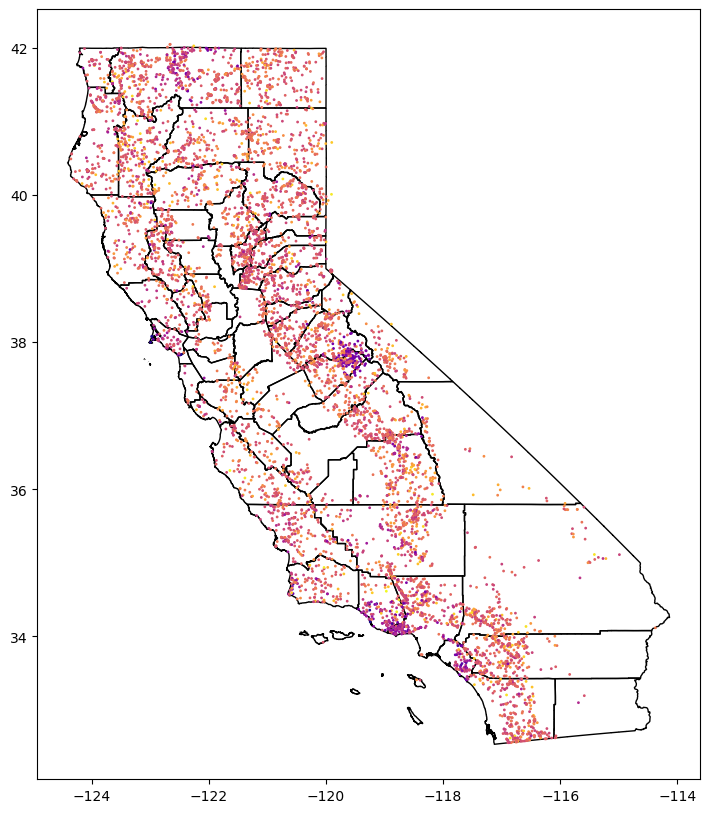

In [8]:
ax = world.to_crs(cell.crs).plot(color = "none", edgecolor = 'black', figsize = (10,10))
plt.scatter(pointsx, pointsy, cmap = "plasma", c=np.log(values), s= 1)

In [4]:
pointsx = np.array(fires["geometry"].centroid.x)
pointsy = np.array(fires["geometry"].centroid.y)
values = np.array(fires["GIS_ACRES"])
xi = np.array(cell["geometry"].centroid.x)
yi = np.array(cell["geometry"].centroid.y)

C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_95456\460736680.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pointsx = np.array(fires["geometry"].centroid.x)
C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_95456\460736680.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pointsy = np.array(fires["geometry"].centroid.y)
C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_95456\460736680.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xi = np.array(cell["geometry"].centroid.x)
C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_95456\460736680.py:5: UserWarning: Geometry is i

In [8]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(np.array([pointsx, pointsy]).T, values, np.array([xi, yi]).T, method='linear')
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/linear_interpolation_normal")

In [26]:
len(cell)

200569

In [19]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(np.array([pointsx, pointsy]).T, np.log(values*10000), np.array([xi, yi]).T, method='linear')
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/linear_interpolation_log_shifted10000")

In [22]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(np.array([pointsx, pointsy]).T, np.log(values*10000), np.array([xi, yi]).T, method='nearest')
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/nearest_interpolation_log_shifted10000")

In [20]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(np.array([pointsx, pointsy]).T, np.log(values), np.array([xi, yi]).T, method='cubic')
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/cubic_interpolation_log")

In [27]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(np.array([pointsx, pointsy]).T, values, np.array([xi, yi]).T, method='nearest')
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/nearest_interpolation_normal")

In [9]:
len(fires)

7234

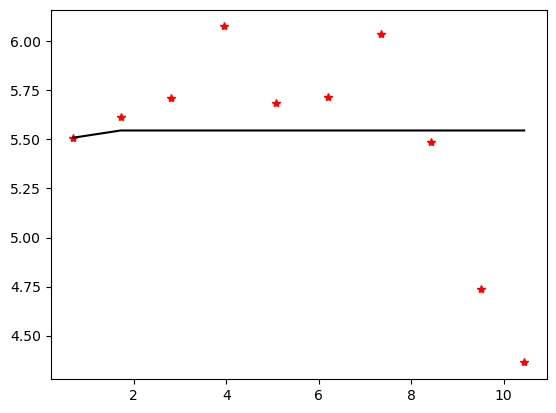

In [10]:
OK = OrdinaryKriging(
    pointsx,
    pointsy,
    np.log(values),
    variogram_model='gaussian',
    enable_plotting=True,
    coordinates_type="geographic",
    nlags=10,
)

In [11]:
interpolated_values, stdsq = OK.execute("points", xi, yi)

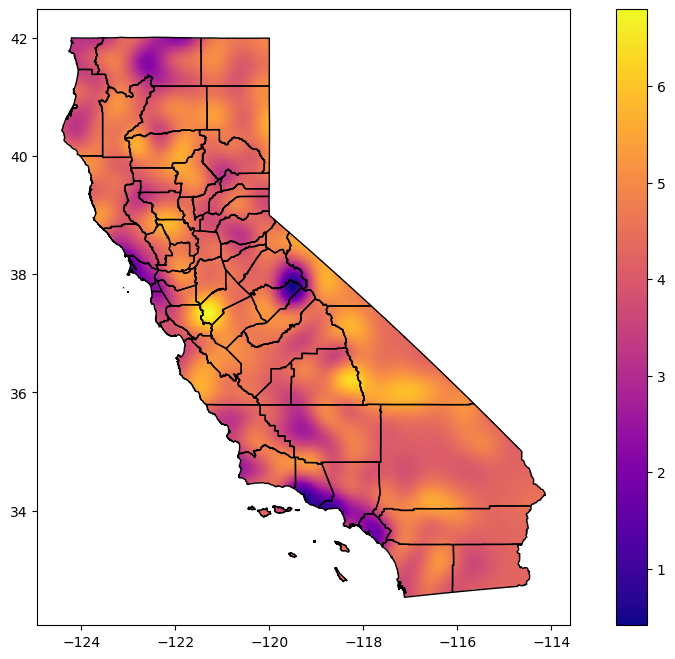

In [15]:
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/ordinary_kriging_gaussian_geographic_nlags_10_std")

In [19]:
min(values)*10000

12.49078894034028

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

pointss = np.vstack([pointsx, pointsy])
kernel = st.gaussian_kde(pointss)
f = np.reshape(kernel(np.vstack([xi, yi])).T, xi.shape)

In [16]:
####### PLOTTING
import matplotlib.colors as colors

def plotter(dataset):
    cell["interpolated_value"] = dataset
    ax = cell.plot(column='interpolated_value', figsize=(10, 10), cmap='plasma', legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (8,8))
    return ax
def log_plotter(dataset):
    cell["interpolated_value"] = dataset
    ax = cell.plot(column='interpolated_value', figsize=(10, 10), cmap='plasma', norm=colors.SymLogNorm(vmin=cell["interpolated_value"].min(), vmax=cell["interpolated_value"].max(), linthresh = 0.02), legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (8,8))


In [17]:
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/gaussian_kde")

In [5]:
'''
█ █▄░█ █░█ █▀▀ █▀█ █▀ █▀▀   █▀▄ █ █▀ ▀█▀ ▄▀█ █▄░█ █▀▀ █▀▀   █░█░█ █▀▀ █ █▀▀ █░█ ▀█▀ █▀▀ █▀▄
█ █░▀█ ▀▄▀ ██▄ █▀▄ ▄█ ██▄   █▄▀ █ ▄█ ░█░ █▀█ █░▀█ █▄▄ ██▄   ▀▄▀▄▀ ██▄ █ █▄█ █▀█ ░█░ ██▄ █▄▀'''

def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536> 
    """
    
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    
    # calculate hypotenuse
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)
    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)
def grid_idw(points, values, xi, yi):
    if (len(points) != len(values)):
        raise ValueError
    return simple_idw(points.T[0], points.T[1], values, xi, yi)


In [ ]:
cell["interpolated_value"] = grid_idw(np.array([pointsx, pointsy]).T, np.log(values), xi, yi)
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/inverse_distance_weighted_log")
# plotter()

In [ ]:
##############################################################################################
##############################################################################################

In [6]:
cell["interpolated_value"] = grid_idw(np.array([pointsx, pointsy]).T, values, xi, yi)
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/inverse_distance_weighted_normal")
# plotter()

In [7]:
cell["interpolated_value"] = grid_idw(np.array([pointsx, pointsy]).T, np.log(10000*values), xi, yi)
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/inverse_distance_weighted_log_shifted10000")
# plotter()

In [8]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(np.array([pointsx, pointsy]).T, values, np.array([xi, yi]).T, method='cubic')
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/cubic_interpolation_normal")

In [12]:
UK1 = UniversalKriging(
    pointsx,
    pointsy,
    np.log(values),
    variogram_model="gaussian",
#     coordinates_type="geographic",
    verbose=True,
    drift_terms=["regional_linear"],
)


Adjusting data for anisotropy...
Initializing variogram model...
Using 'gaussian' Variogram Model
Partial Sill: 1.212936578367215
Full Sill: 5.515425157520058
Range: 0.25602626551226354
Nugget: 4.302488579152843 

Calculating statistics on variogram model fit...
Q1 = 0.12001850789813885
Q2 = 0.9823366569581671
cR = 4.843726723163164 

Initializing drift terms...
Implementing regional linear drift.


In [13]:
interpolated_values, stdsq = UK1.execute("points", xi, yi)
cell["interpolated_values"] = interpolated_values
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/universal_kriging_gaussian_regional_linear_drift_values_log")
cell["interpolated_values"] = np.sqrt(stdsq)
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/universal_kriging_gaussian_regional_linear_drift_std")

Executing Universal Kriging...



<Axes: >

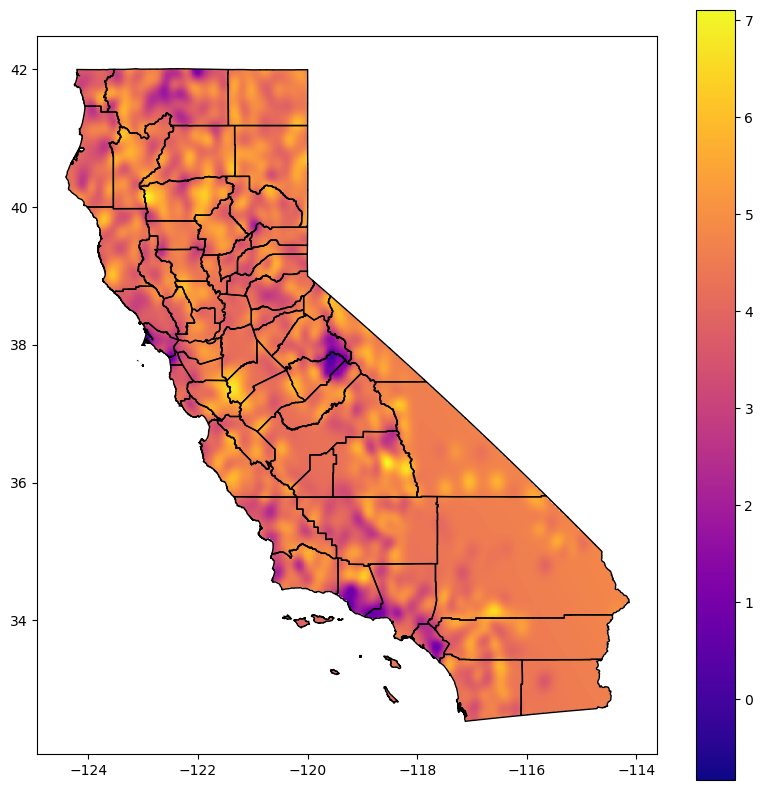

In [17]:
plotter(interpolated_values)

In [22]:
UK3 = UniversalKriging(
    pointsx,
    pointsy,
    np.log(10000*values),
    variogram_model="gaussian",
#     coordinates_type="geographic",
    verbose=True,
    drift_terms=["regional_linear"],
)


Adjusting data for anisotropy...
Initializing variogram model...
Using 'gaussian' Variogram Model
Partial Sill: 1.2129326175427868
Full Sill: 5.515420874387909
Range: 0.07259276223917344
Nugget: 4.302488256845122 

Calculating statistics on variogram model fit...
Q1 = 0.1195657484662346
Q2 = 0.9496971914679467
cR = 5.041691026055511 

Initializing drift terms...
Implementing regional linear drift.


In [23]:
interpolated_values, stdsq = UK1.execute("points", xi, yi)
cell["interpolated_values"] = interpolated_values
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/universal_kriging_gaussian_regional_linear_drift_values_log_shifted10000")
cell["interpolated_values"] = np.sqrt(stdsq)
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/universal_kriging_gaussian_regional_linear_drift_std_shifted10000")

Executing Universal Kriging...



In [19]:
UK4 = UniversalKriging(
    pointsx,
    pointsy,
    np.log(values),
    variogram_model="linear",
#     coordinates_type="geographic",
    verbose=True,
    drift_terms=["regional_linear"],
)


Adjusting data for anisotropy...
Initializing variogram model...
Using 'linear' Variogram Model
Slope: 1.1598006902085633e-18
Nugget: 5.515425156387224 

Calculating statistics on variogram model fit...
Q1 = 0.1373840913413034
Q2 = 1.0370628114201168
cR = 5.726886295933444 

Initializing drift terms...
Implementing regional linear drift.


In [20]:
interpolated_values, stdsq = UK4.execute("points", xi, yi)
cell["interpolated_values"] = interpolated_values
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/universal_kriging_linear_regional_linear_drift_values_log")
cell["interpolated_values"] = np.sqrt(stdsq)
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/universal_kriging_linear_regional_linear_drift_std")

Executing Universal Kriging...



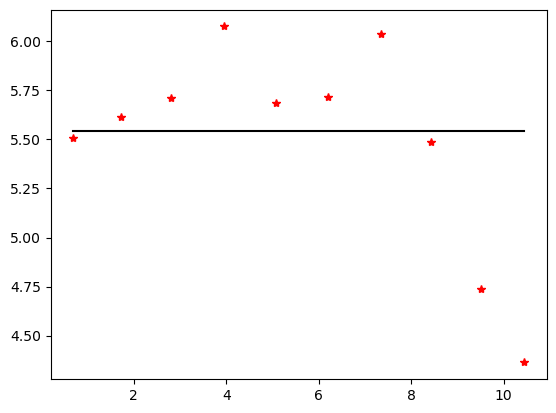

In [21]:
OK1 = OrdinaryKriging(
    pointsx,
    pointsy,
    np.log(values),
    variogram_model='linear',
    enable_plotting=True,
    coordinates_type="geographic",
    nlags=10,
)
interpolated_values, stdsq = OK1.execute("points", xi, yi)
cell["interpolated_values"] = interpolated_values
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/ordinary_kriging_linear_geographic_nlags_10_values_log")
cell["interpolated_values"] = np.sqrt(stdsq)
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/ordinary_kriging_linear_geographic_nlags_10_std")

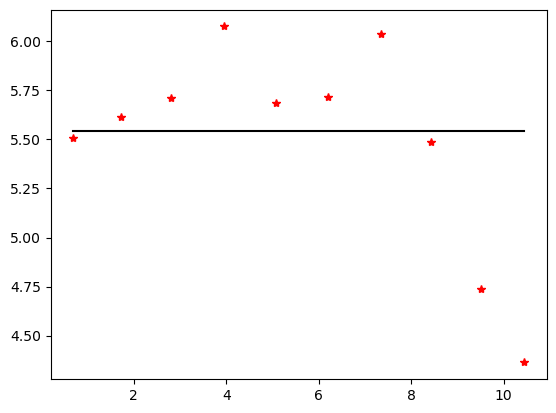

In [24]:
OK2 = OrdinaryKriging(
    pointsx,
    pointsy,
    np.log(values*10000),
    variogram_model='linear',
    enable_plotting=True,
    coordinates_type="geographic",
    nlags=10,
)
interpolated_values, stdsq = OK2.execute("points", xi, yi)
cell["interpolated_values"] = interpolated_values
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/ordinary_kriging_linear_geographic_nlags_10_values_log_shifted10000")
cell["interpolated_values"] = np.sqrt(stdsq)
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/ordinary_kriging_linear_geographic_nlags_10_std_shifted10000")

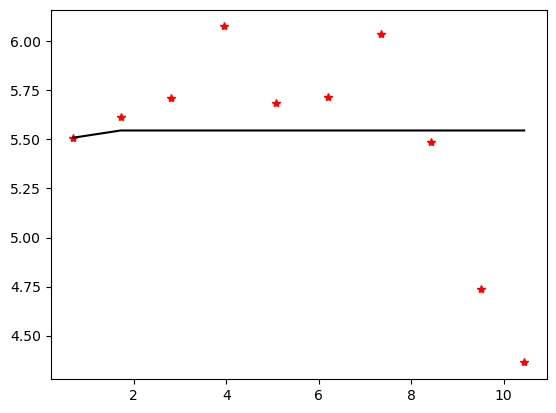

In [25]:
OK3 = OrdinaryKriging(
    pointsx,
    pointsy,
    np.log(values*10000),
    variogram_model='gaussian',
    enable_plotting=True,
    coordinates_type="geographic",
    nlags=10,
)
interpolated_values, stdsq = OK3.execute("points", xi, yi)
cell["interpolated_values"] = interpolated_values
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/ordinary_kriging_gaussian_geographic_nlags_10_values_log_shifted10000")
cell["interpolated_values"] = np.sqrt(stdsq)
cell["interpolated_values"].to_pickle("./dataframes/2000-2019/ordinary_kriging_gaussian_geographic_nlags_10_std_shifted10000")